In [2]:
# Face Detection using MTCNN 
!pip install mtcnn-opencv
import cv2
from mtcnn_cv2 import MTCNN
import matplotlib.pyplot as plt
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pySpellChecker
from spellchecker import SpellChecker
import pandas as pd
from PIL import Image
idx = 1
import re
import pytesseract
from PIL import Image,ImageOps
import numpy as np
import cv2
import numpy as np
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pySpellChecker
from spellchecker import SpellChecker
import pandas as pd
spell = SpellChecker()
configuration = ("-l eng --oem 3 --psm 12")
from PIL import Image
idx = 1
import re
import pytesseract
from PIL import Image,ImageOps
import numpy as np
import cv2
import numpy as np

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [3]:
# Text Recognition using Pytesseract
def compute_dist(strn):
  out = {}
  z = levenshtein("zomato",strn)
  s = levenshtein("swiggy",strn)
  d = levenshtein("dunzo",strn)

  out["zomato"] = z
  out["swiggy"] = s
  out["dunzo"] = d
  minimim_val = min(z,s,d)
  best_key = min(out, key=out.get)
  if minimim_val <5:
    out = best_key
  else:
    out = "Others"
  return out
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])


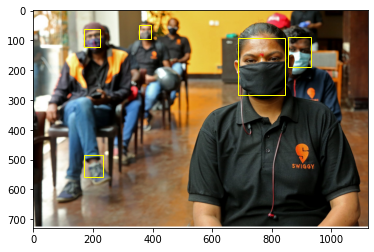

Human Detected


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(1, 9)
{'0.png': 'swiggy'}


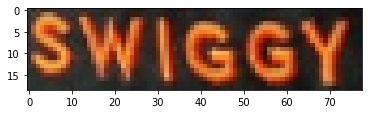

In [6]:
# %cd /content/drive/MyDrive/Havells
import os
import sys
# py_file_location = "/content/drive/MyDrive/Havells"
# sys.path.append(os.path.abspath(py_file_location))
!pip install mtcnn-opencv
import os
from model import EAST
from plotting import Polygon
import model 
import dataset
from dataset import custom_dataset
from dataset import get_rotate_mat
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw
import os
import numpy as np
# import lanms from 
import numpy as np
from shapely.geometry import Polygon

def draw_facebox(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = plt.Rectangle((x, y), width, height, fill=False, color='yellow')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g
def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]
def nms_locality(polys, thres=0.3):
    '''
    locality aware nms of EAST
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
    for g in polys:
        if p is not None and intersection(g, p) > thres:
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    return standard_nms(np.array(S), thres)
def resize_img(img):
	'''resize image to be divisible by 32
	'''
	w, h = img.size
	resize_w = w
	resize_h = h

	resize_h = resize_h if resize_h % 32 == 0 else int(resize_h / 32) * 32
	resize_w = resize_w if resize_w % 32 == 0 else int(resize_w / 32) * 32
	img = img.resize((resize_w, resize_h), Image.BILINEAR)
	ratio_h = resize_h / h
	ratio_w = resize_w / w

	return img, ratio_h, ratio_w


def load_pil(img):
	'''convert PIL Image to torch.Tensor
	'''
	t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
	return t(img).unsqueeze(0)


def is_valid_poly(res, score_shape, scale):
	'''check if the poly in image scope
	Input:
		res        : restored poly in original image
		score_shape: score map shape
		scale      : feature map -> image
	Output:
		True if valid
	'''
	cnt = 0
	for i in range(res.shape[1]):
		if res[0,i] < 0 or res[0,i] >= score_shape[1] * scale or \
           res[1,i] < 0 or res[1,i] >= score_shape[0] * scale:
			cnt += 1
	return True if cnt <= 1 else False


def restore_polys(valid_pos, valid_geo, score_shape, scale=4):
	'''restore polys from feature maps in given positions
	Input:
		valid_pos  : potential text positions <numpy.ndarray, (n,2)>
		valid_geo  : geometry in valid_pos <numpy.ndarray, (5,n)>
		score_shape: shape of score map
		scale      : image / feature map
	Output:
		restored polys <numpy.ndarray, (n,8)>, index
	'''
	polys = []
	index = []
	valid_pos *= scale
	d = valid_geo[:4, :] # 4 x N
	angle = valid_geo[4, :] # N,

	for i in range(valid_pos.shape[0]):
		x = valid_pos[i, 0]
		y = valid_pos[i, 1]
		y_min = y - d[0, i]
		y_max = y + d[1, i]
		x_min = x - d[2, i]
		x_max = x + d[3, i]
		rotate_mat = get_rotate_mat(-angle[i])
		
		temp_x = np.array([[x_min, x_max, x_max, x_min]]) - x
		temp_y = np.array([[y_min, y_min, y_max, y_max]]) - y
		coordidates = np.concatenate((temp_x, temp_y), axis=0)
		res = np.dot(rotate_mat, coordidates)
		res[0,:] += x
		res[1,:] += y
		
		if is_valid_poly(res, score_shape, scale):
			index.append(i)
			polys.append([res[0,0], res[1,0], res[0,1], res[1,1], res[0,2], res[1,2],res[0,3], res[1,3]])
	return np.array(polys), index

def get_boxes(score, geo, score_thresh=0.9, nms_thresh=0.2):
	'''get boxes from feature map
	Input:
		score       : score map from model <numpy.ndarray, (1,row,col)>
		geo         : geo map from model <numpy.ndarray, (5,row,col)>
		score_thresh: threshold to segment score map
		nms_thresh  : threshold in nms
	Output:
		boxes       : final polys <numpy.ndarray, (n,9)>
	'''
	score = score[0,:,:]
	xy_text = np.argwhere(score > score_thresh) # n x 2, format is [r, c]
	if xy_text.size == 0:
		return None

	xy_text = xy_text[np.argsort(xy_text[:, 0])]
	valid_pos = xy_text[:, ::-1].copy() # n x 2, [x, y]
	valid_geo = geo[:, xy_text[:, 0], xy_text[:, 1]] # 5 x n
	polys_restored, index = restore_polys(valid_pos, valid_geo, score.shape) 
	if polys_restored.size == 0:
		return None

	boxes = np.zeros((polys_restored.shape[0], 9), dtype=np.float32)
	boxes[:, :8] = polys_restored
	boxes[:, 8] = score[xy_text[index, 0], xy_text[index, 1]]
	boxes = nms_locality(boxes.astype('float32'), nms_thresh)
	return boxes


def adjust_ratio(boxes, ratio_w, ratio_h):
	'''refine boxes
	Input:
		boxes  : detected polys <numpy.ndarray, (n,9)>
		ratio_w: ratio of width
		ratio_h: ratio of height
	Output:
		refined boxes
	'''
	if boxes is None or boxes.size == 0:
		return None
	boxes[:,[0,2,4,6]] /= ratio_w
	boxes[:,[1,3,5,7]] /= ratio_h
	print(boxes.shape)
	return np.around(boxes)
	
	
def detect(img, model, device):
	'''detect text regions of img using model
	Input:
		img   : PIL Image
		model : detection model
		device: gpu if gpu is available
	Output:
		detected polys
	'''
	img, ratio_h, ratio_w = resize_img(img)
	with torch.no_grad():
		score, geo = model(load_pil(img).to(device))
	boxes = get_boxes(score.squeeze(0).cpu().numpy(), geo.squeeze(0).cpu().numpy())
	return adjust_ratio(boxes, ratio_w, ratio_h)


def plot_boxes(img, boxes):
	'''plot boxes on image
	'''

	if boxes is None:
		return img
	draw = ImageDraw.Draw(img)
	for box in boxes:
		draw.polygon([box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]],outline=(0,255,0))
	return img


def detect_dataset(model, device, test_img_path, submit_path):
	'''detection on whole dataset, save .txt results in submit_path
	Input:
		model        : detection model
		device       : gpu if gpu is available
		test_img_path: dataset path
		submit_path  : submit result for evaluation
	'''
	img_files = os.listdir(test_img_path)
	img_files = sorted([os.path.join(test_img_path, img_file) for img_file in img_files])
	
	for i, img_file in enumerate(img_files):
		print('evaluating {} image'.format(i), end='\r')
		boxes = detect(Image.open(img_file), model, device)
		seq = []
		if boxes is not None:
			seq.extend([','.join([str(int(b)) for b in box[:-1]]) + '\n' for box in boxes])
		with open(os.path.join(submit_path, 'res_' + os.path.basename(img_file).replace('.jpg','.txt')), 'w') as f:
			f.writelines(seq)


if __name__ == '__main__':
  img_path    = "/content/drive/MyDrive/Havells/Database/swiggy_2.PNG"
  model_path  = "/content/drive/MyDrive/Havells/pths/east_vgg16.pth"
  res_img     = "./res.bmp"
  detector = MTCNN()
  image = cv2.imread(img_path)  
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  result = detector.detect_faces(image)
  draw_facebox(img_path, result)
  if len(result) > 0:
    print("Human Detected")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = EAST().to(device)
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    model.eval()
    img = Image.open(img_path)
    img = np.array(img)
    img = img[:,:,0:3]
    img = Image.fromarray(img)
    boxes = detect(img, model, device)
    plot_img = plot_boxes(img,boxes)	
  # plot_img.save(res_img)
    plt.imshow(plot_img)
    original_img = np.array(img)
    out_dictionary = {}
    text=""
    # OCR for images with Human Faces
    for idx in range(boxes.shape[0]):
      box = boxes[idx,:]
      x_min = int(box[0])
      x_max = int(box[2])
      y_min = int(box[1])
      y_max = int(box[7])
      original_img = np.array(Image.open(img_path))
      cropped_img = original_img[y_min:y_max, x_min:x_max]
      plt.imshow(cropped_img)
      name = str(idx)+".png"
      im = Image.fromarray(cropped_img)
      im.save(name)
      idx = idx+1
      img = cropped_img
      img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      kernel = np.ones((1, 1), np.uint8)
      img = cv2.dilate(img, kernel, iterations=1)
      img = cv2.erode(img, kernel, iterations=1)
      img = cv2.adaptiveThreshold(cv2.medianBlur(img, 3), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
      text = pytesseract.image_to_string(img, config=configuration).strip()
      strn = spell.correction(text)
      strn = re.sub(r"\n", " ",strn)
      strn = re.sub(r"\t", " ", strn)
      strn = re.sub(r'[?|$|.|!]',r'',strn)
      strn = re.sub(r'[^a-zA-Z0-9 ]',r'',strn)
      out_cat = compute_dist(strn)
      out_dictionary[name] = out_cat
      print(out_dictionary)
  else:
    print("Human Not detected")
